<a href="https://colab.research.google.com/github/webrockerz2020/waste_classifcation_traditional_machine_learning/blob/main/waste_classification_using_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm
from tqdm import tqdm
import threading
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
#Connecting the driver
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Setting all the directories

root = '/content/drive/MyDrive/ML/data'
#style_file = 'styles.csv'
image_folder_train = root + '/train/'
image_folder_train_o =image_folder_train + 'O/'
image_folder_train_r =image_folder_train + 'R/'

In [3]:
# Feature Engineering using HoG
def get_all_image_names_and_its_class_to_df(folder_name):
    #print(folder_name)
    df_local=pd.DataFrame(columns=['id','masterCategory'])
    for folder in os.listdir(folder_name):
      #print(folder)
      if folder != '.DS_Store':
            folder_path =os.path.join(folder_name,folder)
            #print(folder_path)
            temp_df=pd.DataFrame(columns=['id','masterCategory'])
            img_list=[]
            for img in os.listdir(folder_path):
                img_list.append(img)
            #print(folder)
            temp_df['id'] =img_list
            temp_df['masterCategory']= folder
            #print(temp_df)
            df_local = pd.concat([df_local, temp_df], ignore_index=True)
    return df_local

# Loading the images
def load_image(ids, path):
    img = cv.imread(path + ids, cv.IMREAD_GRAYSCALE)
    return img, ids

def process_image(id_path_tuple):
    id, path = id_path_tuple
    img, id = load_image(id, path)
    if img is not None:
        return [img, id]

# resizing of images
def resize_image(img,ids):
    return cv.resize(img, (60, 80),interpolation =cv.INTER_LINEAR) # Tired with 60,80 # tired 60,60 # tired 100 by 100 system crash

#bluring the images
def hog_to_blur_the_images(image):
    ppcr = 8 # tired with 8
    ppcc = 8 # Tired with 8
    blur = cv.GaussianBlur(image, (7, 7), 0) #kernal size 5 checked , # larger kernel more blur
    fd, hog_image = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True)
    return hog_image, fd

#get the edges
def get_edges(img_list,n_sample):
  edges = [cv.Canny(image,50,150,apertureSize = 3) for image in img_list]
    #edges = [cv.Canny(image, 30, 90, apertureSize=3) for image in img_lst]

  edges = np.array(edges)
  #print(edges)
  n_samples_edges = len(edges)
  edge_images_train = edges.reshape((n_samples, -1))
  edge_images_train.shape



In [4]:
# Loading all the images
df_train = get_all_image_names_and_its_class_to_df(image_folder_train)
print(df_train.shape)
print(df_train.head(10))
print(df_train['masterCategory'].value_counts())

(25077, 2)
            id masterCategory
0  O_13532.jpg              O
1  O_13491.jpg              O
2  O_12957.jpg              O
3  O_12638.jpg              O
4  O_13042.jpg              O
5  O_13724.jpg              O
6  O_13095.jpg              O
7  O_13081.jpg              O
8  O_13917.jpg              O
9  O_12823.jpg              O
<bound method DataFrame.value_counts of                 id masterCategory
0      O_13532.jpg              O
1      O_13491.jpg              O
2      O_12957.jpg              O
3      O_12638.jpg              O
4      O_13042.jpg              O
...            ...            ...
25072  R_10238.jpg              R
25073  R_10056.jpg              R
25074  R_10123.jpg              R
25075  R_10121.jpg              R
25076  R_10208.jpg              R

[25077 rows x 2 columns]>


In [7]:
# Mulitprocessing 1
def create_a_multiprocessing(folder_name,df):
    df_ids = list(df.id)
    # Create a list of (id, path) tuples
    id_path_tuples = [(id, folder_name) for id in df_ids]
    # Create a multiprocessing pool
    pool = Pool(processes=8)
    # Process images in parallel
    results = list(tqdm(pool.imap(process_image, id_path_tuples), total=len(df_ids)))
    # Close the pool
    pool.close()
    pool.join()
    images= [result for result in results if result is not None]
    len(images)
    return images

In [8]:
train_images_o =create_a_multiprocessing(image_folder_train_o,df_train)
train_images_r =create_a_multiprocessing(image_folder_train_r,df_train)
all_train_images = train_images_o+train_images_r
print("Length of train images",len(all_train_images))

100%|██████████| 25077/25077 [07:41<00:00, 54.29it/s]

Length of train images 25077


In [10]:
all_images_resized_train = [[resize_image(x,y),y] for x,y in all_train_images]
df_labels_train = pd.DataFrame(all_images_resized_train,columns=['image','id'])


In [12]:
# Adding all the labels
target = 'masterCategory'
df_labels_train = pd.merge(df_labels_train,df_train,how='left',on=['id'])
df_labels_train = df_labels_train.fillna('Others')
df_labels_train['class'] = pd.factorize(df_labels_train[target])[0]
print("Data Shape: ", str(df_labels_train.shape))
print(df_labels_train[target].value_counts())

Data Shape:  (25077, 4)
O    13966
R    11111
Name: masterCategory, dtype: int64


In [13]:
train_images = np.stack(df_labels_train.image.values,axis=0)
n_samples_train = len(train_images)
print(n_samples_train)
data_images_train = train_images.reshape((n_samples_train, -1))

25077


In [14]:
# Multiprocessing 2
def create_a_multiprocessing_blur(image_lst):
    pool = Pool(processes=5)
    hog_images, hog_features = zip(*pool.map(hog_to_blur_the_images, image_lst))
    pool.close()
    pool.join()

    hog_features = np.array(hog_features)
    return hog_images, hog_features

In [15]:
hog_images_train, hog_features_train = create_a_multiprocessing_blur(train_images)

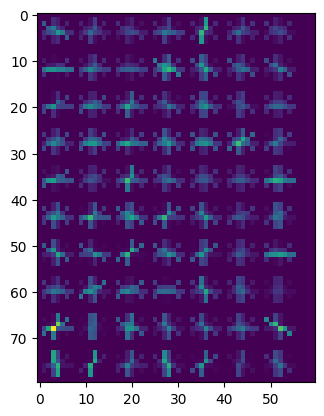

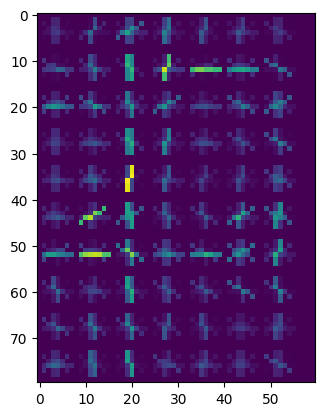

In [17]:
for img in hog_images_train[:2]:
    plt.imshow(img)
    plt.show()

In [18]:
def get_edges(img_lst,n_samples):
  edges = [cv.Canny(image,50,150,aperture = 3) for image in img_lst]
  #edges = [cv.Canny(image, 30, 90, apertureSize=3) for image in img_lst]

  edges = np.array(edges)
  #print(edges)
  n_samples_edges = len(edges)
  edge_images = edges.reshape((n_samples, -1))
  edge_images.shape
  return edge_images

In [19]:
train_images.shape


(25077, 80, 60)

In [42]:
edges = [cv.Canny(image,50,150,apertureSize = 3) for image in train_images]
  #edges = [cv.Canny(image, 30, 90, apertureSize=3) for image in img_lst]

edges = np.array(edges)
#print(edges)
n_samples_edges = len(edges)
edge_images_train = edges.reshape((n_samples_train, -1))
edge_images_train.shape

(25077, 4800)

In [21]:
train_images.shape, hog_features_train.shape, edge_images_train.shape


((25077, 80, 60), (25077, 1080), (25077, 4800))

In [22]:
edge_hog_train = np.hstack([hog_features_train,edge_images_train])
edge_hog_train.shape

(25077, 5880)

In [23]:
histr_train = [cv.calcHist([img],[0],None,[256],[0,256]) for img in train_images]
histr_train = np.array(histr_train)
n_samples_histr_train = len(histr_train)
image_hist_train = histr_train.reshape((n_samples_histr_train, -1))
image_hist_train.shape


(25077, 256)

In [25]:
# Models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hog_features_train, df_train['masterCategory'], test_size=0.3, random_state=42)

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17553, 1080) (17553,)
(7524, 1080) (7524,)


In [30]:
y_train.value_counts()

O    9774
R    7779
Name: masterCategory, dtype: int64

In [31]:
#KNN
from sklearn import datasets, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [33]:
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

for i in range(3,10):
  print(i)
  classifier = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  classifier.fit(X_scaled, y_train)
  test_accuracy = classifier.score(scaler.transform(X_test), y_test)
  print(test_accuracy)

3
0.7076023391812866
4
0.7161084529505582
5
0.7177033492822966
6
0.7252791068580542
7
0.7259436469962786
8
0.7290005316321105
9
0.7292663476874003


In [34]:
for i in range(10,15):
  print(i)
  classifier = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  classifier.fit(X_scaled, y_train)
  test_accuracy = classifier.score(scaler.transform(X_test), y_test)
  print(test_accuracy)

10
0.73471557682084
11
0.732589048378522
12
0.7340510366826156
13
0.7317916002126529
14
0.732589048378522


In [38]:
#Logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier = LogisticRegression(max_iter=6)
classifier.fit(X_scaled, y_train)
test_accuracy = classifier.score(scaler.transform(X_test), y_test)
print(test_accuracy)

0.7091972355130249
